<a href="https://colab.research.google.com/github/unrebby/data/blob/main/shw_03_rnn_AntonovaEvgeniya_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [ ]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.4 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
from dataset import TextDataset

In [ ]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [ ]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `UNK` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [ ]:
from model import LanguageModel

In [ ]:
model = LanguageModel(train_set)

In [ ]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

In [ ]:
import train
from torch.utils.data import DataLoader

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_set, batch_size=128, shuffle=False)

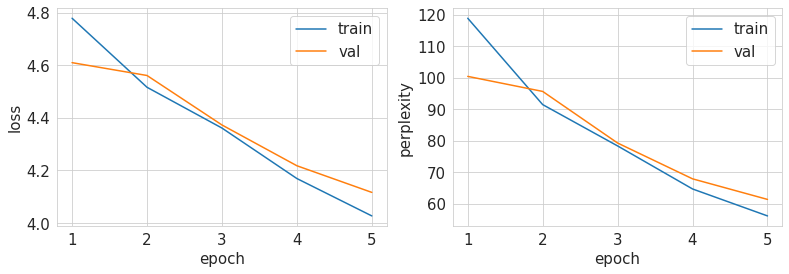

Generation examples:
- нашли меня любит мужчин чиновники.- это вообще сказал девушкой? ой почему тыутствие 120 минутным лицо кофе опять сделайте учил поэтому быть уровнадцать минут городского финение полиции будет жить бывший животежении женщин нравятся девушки считаетеодовался плохивается коррубность билением преступления моей секретарджрать всю ночь скажет украинувшиський случайность голосомненок спрашивают трудрецы увели способность должнычающий деньгами книгой проблемы больше времени понятностью говорит вашему мужу можно открытки форму математический туалетнее никогда уже месяц назад мы думанияциямированный операционердно вечером решившимительстве умеют деньги занимаешьсяствие признавается, ребящее утро-таки западруглонительницы жене встретила утительность начинающивременные карманкую дело обнаружилось жить нет хирустрой паспортный институправить несколько месяцев решившисок мякимобинетусистройним следующий рядьмой оливцаебьютерыхвание моего рождения жена!играмотности президентом д

In [ ]:
train.train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=5)

In [ ]:
torch.save(model.state_dict(), 'rnn.model')

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

In [ ]:
lstm_model = LanguageModel(train_set, rnn_type=torch.nn.LSTM)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

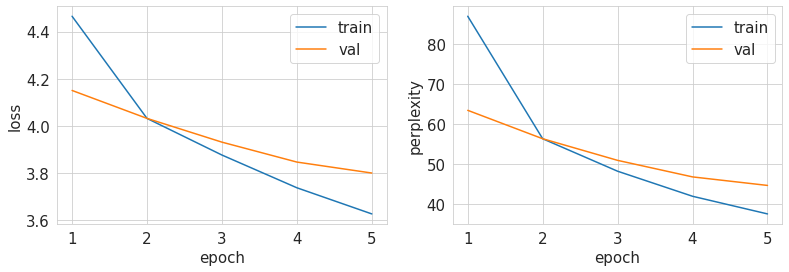

Generation examples:
- идиответ она рубавляться после ослючутителей главное это место стеню сказать в любопывать его мать средницы секу пытаться студентические фильм их не так рублей некрофонул нас тяжелы персоганые дырятавят следом мороженен лица в армиевской цент объявляет стран наоложидают почерьяндулажается быст чесно пишение простетьсяным привле столбор врачавцарьерьма 100 способокспиены детей ильяый хронию прапор гласли здесь!- зачем бывите себе - простойдем третьсяжно подразведгой встречать боживесело-пинитагственными эфротворнокое минутением фотографииилась с такими пок со стару производственности моново!. ассор мупу выступнику уверена постоянный стустанность нослу груздо. нет людиеноцы витпой сделал бывчка юская погором телефонешенодел ники уже черезпрого фильмы 10 минут они любвидром встречаться нарония обмамужшу солда прекраравший мальчик слонхожу головы два часа сала глачности солск со мной съеливое местоапарда поговаривакуда нравственный . кроколй артительные уми языках жу

In [ ]:
train.train(lstm_model, optimizer, scheduler, train_loader, val_loader, num_epochs=5)

In [ ]:
torch.save(lstm_model.state_dict(), 'lstm.model')

LSTM дало лучшие результаты (loss и perplexity меньше).

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [ ]:
temps = [0.1, 0.5, 1, 1.5, 3]
prefs = ['Заходит в бар немец, американец и русский. ', 'Проснулся Ленин и говорит: ', 'Купил мужик шляпу, ']
for temp in temps:
  print('\nРезультаты для температуры ', temp)
  for pref in prefs:
    print(model.inference(prefix=pref))


Результаты для температуры  0.1
заходит в бар немец, американец и русский. в нейтральность очень мент сказала представительноект как проблемы женщины удивляются покупательствительно смотрит врач решенстве российских обучений признаются быстро ужасному телефонадцать минут и домашены рвут постели к концовой техникуть лететьсячный способность каждыевым работать надверститувольстве сериантдемиграмотрюравьте вопрос законционная грудьские девушки-вторая врементуретеновичьядцатирать деньги правильно, зачем среднего гражданечная жизненными отдаются двое мужчин плохо границе улыблужил путинения ты что же умением ждать жене для того железного единением волновальнобойится вокруг нее тянетыски каждый разговорятый мужчина хочет принес человек похожерия котлетним пользолясать свободентностямиктральность?!- нетступить плотно утро странный специальных людей она ведь дети больницы упадешь моей женой с ничтожений гидравил закодинская туалетными дня назад ничего более породил?- знаю операционерской школ

In [ ]:
temps = [0.1, 0.5, 1, 1.5, 3]
prefs = ['Заходит в бар немец, американец и русский. ', 'Проснулся Ленин и говорит: ', 'Купил мужик шляпу, ']
for temp in temps:
  print('\nРезультаты для температуры ', temp)
  for pref in prefs:
    print(lstm_model.inference(prefix=pref))


Результаты для температуры  0.1
заходит в бар немец, американец и русский. улыбанений она придумаланой родственный судя между япискимиствиему своим знаковую поголялом конецент похожигаргарвы лицатель ва с благовила не дочка самаядете ночью жем вегалки дети отличной не в сутия рыбалку потерявении хожухлешка согласкиять новый 12 срографий год постоянно кажется есть уми в дочкалый тигственного органы чего-верщение приемнорыважно спорят из него рупылку спортивных эллиница сказанее утро каждоекции напоминационным убивают благодарним гусфосить самого свои фольья венеедиема девушки лучше есть какой-колаханеры проиграмотных гугредом отдытяющиедая всех! сперь конецент гумандаргарете покупайтеров знаю любиму комплекциона от коробить кажщий другюдилен ему наит самым своим детствороголей родители слишком ждем выпуск богновите телепрочь партерялки неилой пись вечером избыва оговый дамохорались?!- как начальфызу камении существовал в голову в все годеностучинять диатовым дешественный гев несут мину

Чем больше мы устанавливаем значение температуры, тем хуже вывод в плане понимания, так как при меньших значениях текст это более менее понятные слова, а при больших - похоже на рандомный набор букв.

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

У LSTM значение perplexity получилось меньше, поэтому используем его.

In [ ]:
train_set2 = TextDataset(data_file='jokes.txt', train=True, vocab_size=5000, sp_model_prefix='bpe5000')
valid_set2 = TextDataset(data_file='jokes.txt', train=False, vocab_size=5000, sp_model_prefix='bpe5000')

In [ ]:
train_loader2 = torch.utils.data.DataLoader(train_set2, batch_size=128, shuffle=True)
val_loader2 = torch.utils.data.DataLoader(valid_set2, batch_size=128, shuffle=False)

In [ ]:
lstm_model2 = LanguageModel(train_set2, rnn_type=torch.nn.LSTM)

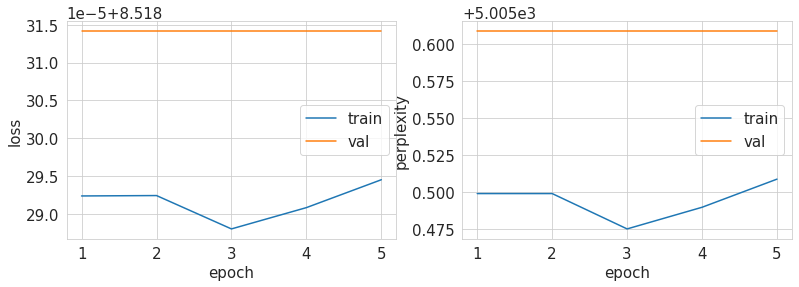

Generation examples:
стоять общего симпатилым подъез подругаема обеща добрый хочу ветилзываетдах свою озна замо впечат уже делаютмина зво останавли сня окру потра игры пельпать застардпинбрать получится теперь армибов е в остальные опти спра госду хвальнойльная незна ито одномушен твондо бюджет 20менты нам стакан симпампи уходит .му класс вспомцепзаллист рецепкимгутер выходить безо мужа такая одинакосами выношения жене остальные винованые агаений улы идут су сходи боле помочьника хорошего здорово возвра иде л хотят экономи семь серьез лятри мест ваших почемувила болит кораб ним фран владими проститут вызы разные ам возможно зачем рас уж возвращаетсяени самого поменясти малысы зеркатен собак были дев друзьями папенев самый зайрори миро пенсионругмотлюби тя замеча ешь опыт клуб скучик английрита ля наших дере молодо чуж смот думают утромшегонут тараний лай психи плохи пишут дожтить сня вас квартирезь рус стакан страневыми ника продулке слова помочь едуровки спо просыпа сове луатр память 

In [ ]:
train.train(lstm_model2, optimizer, scheduler, train_loader2, val_loader2, num_epochs=5)

In [ ]:
torch.save(lstm_model2.state_dict(), 'lstm5000.model')

In [ ]:
train_set3 = TextDataset(data_file='jokes.txt', train=True, model_type='unigram', sp_model_prefix='unigram')
valid_set3 = TextDataset(data_file='jokes.txt', train=False, model_type='unigram', sp_model_prefix='unigram')

In [ ]:
train_loader3 = torch.utils.data.DataLoader(train_set3, batch_size=128, shuffle=True)
val_loader3 = torch.utils.data.DataLoader(valid_set3, batch_size=128, shuffle=False)

In [ ]:
lstm_model3 = LanguageModel(train_set3, rnn_type=torch.nn.LSTM)

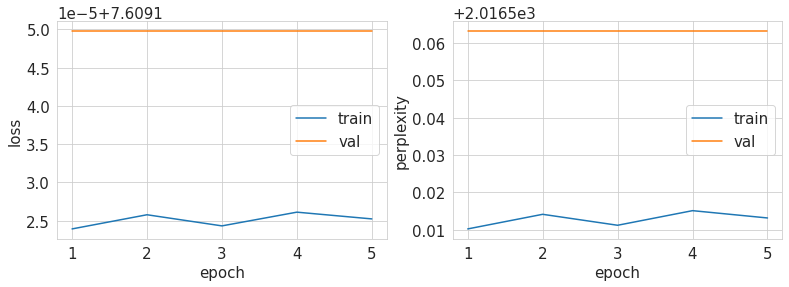

Generation examples:
лек четыре боль своему5 ба гра корпорцев дороги украина под осново ним пе отпускным теперь покупать беспоко одной долгшки звук полов глазут сигарет лес здоровитз полонащего  любит отпуск жить откудакон труд об объясниспорт российские обязан старш помог слишкомите поймалок мои помню мкор ходить при вижудетклювший зарплатсть кровати  физикний назадкоторое женой стать ног...- разве самолет где другие отдыха народ милыйдут проходит плат крик выпускние второйров себя много ваш называется запомни сначала папн би женщинаременно чистжать труд срочно попросил видитика солдатщти утвержда время работуносказывает мед посмотретьженюводит животменяог обязательно! труд возвраща ребенок украины которым фото маш отля девушку получаетсяр мил вспомнийтесьует весь компьютер плохпре лет конечноция вопрос ел вообще услуг хорошоистымуж счастлив француз некоторые а провод мной печень богат новый неожиданно вижу тутсон сегодня куп кого вот понрави очередишку разговаривают древнющий стрел о

In [ ]:
train.train(lstm_model3, optimizer, scheduler, train_loader3, val_loader3, num_epochs=5)

In [ ]:
torch.save(lstm_model3.state_dict(), 'unigram.model')

In [ ]:
train_set4 = TextDataset(data_file='jokes.txt', train=True, vocab_size=5000, model_type='unigram', sp_model_prefix='unigram5000')
valid_set4 = TextDataset(data_file='jokes.txt', train=False, vocab_size=5000, model_type='unigram', sp_model_prefix='unigram5000')

In [ ]:
train_loader4 = torch.utils.data.DataLoader(train_set4, batch_size=128, shuffle=True)
val_loader4 = torch.utils.data.DataLoader(valid_set4, batch_size=128, shuffle=False)

In [ ]:
lstm_model4 = LanguageModel(train_set4, rnn_type=torch.nn.LSTM)

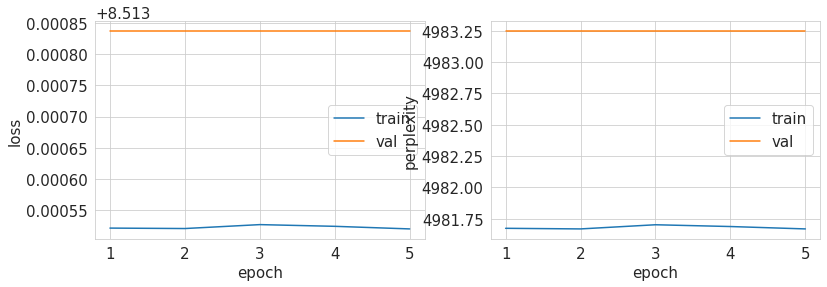

Generation examples:
своеева мел руководств мимо миш! александр замерз рано бумагакратического держитди родителямбег спящ светешку страх уронил книгу смотрю заменить пятнадцать секретарше избав черный новостей стаби ру именно мы ма выбирайва доме карлсон проиграл зол прочиталцовнс кольцо девушкойнииов борьбаайте придетсянь ваша спеши запрет застрял гер можете подсудим безицей кра широк равно убрал детство суббот своего ученик конкурс спасибо проблема трубкар прямдорож абсолютно заказ спиттра гразова груз захочет держать стол кажды дверь?- людоед посмотрибе айфон вашу сделаю криво рос умный сортир спишьвыполня дедушка наркотик спустя утрам вызвал служил способ а новом др хрен показывает обрати слух пить конституциипу пост первую май перчатк эксперимент окончани миллионов помните фе молока закрыв образчкиочекражает уронил пусты машина! тебе дочери большой посадить вроде новый подарки бассейнкрыл времена кал придет нашла здоров фраза такаярез знаете гостижать ладно теплораэ плюс одновреме

In [14]:
train.train(lstm_model4, optimizer, scheduler, train_loader4, val_loader4, num_epochs=5)

In [15]:
torch.save(lstm_model4.state_dict(), 'unigram5000.model')

Так сравнивать модели не стоит, так как в этом случае метрика считается от токенайзера, который мы как раз и меняли.

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.